## STEP:1 - Import all required libraries

In [1]:
import os
import sys
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
USE_SAVED_DATA = True

#### EMOTION MAPPING of both Datasets -- RAVDESS & TESS

In [3]:
RAVDESS_EMOTION_MAP = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fear",
    "07": "disgust",
    "08": "surprise"
}

TESS_EMOTION_MAP = {
    "angry": "angry",
    "disgust": "disgust",
    "fear": "fear",
    "happy": "happy",
    "neutral": "neutral",
    "sad": "sad",
    "pleasant_surprise": "surprise"
}

## STEP:2 - FEATURE EXTRACTION (SAME FOR BOTH DATASETS)

In [4]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, duration=3, offset=0.5)

    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
    tonnetz = np.mean(
        librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T,
        axis=0
    )

    return np.hstack([mfcc, chroma, mel, contrast, tonnetz])

## STEP:3 - LOAD RAVDESS DATASET (RAVDESS Speech + Song)
#### RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song) 

In [5]:
def load_ravdess_dataset(dataset_path):
    X, y = [], []

    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".wav"):
                try:
                    emotion_code = file.split("-")[2]
                    emotion = RAVDESS_EMOTION_MAP[emotion_code]

                    file_path = os.path.join(root, file)
                    features = extract_features(file_path)

                    X.append(features)
                    y.append(emotion)

                except Exception as e:
                    print("Error processing:", file, e)

    return X, y

## STEP:4 - LOAD TESS DATASET 
#### TESS (Toronto Emotional Speech Set)

In [6]:
def load_tess_dataset(dataset_path):
    X, y = [], []

    for file in os.listdir(dataset_path):
        if file.endswith(".wav"):
            file_path = os.path.join(dataset_path, file)

            # Extract emotion from filename
            emotion = file.split("_")[-1].replace(".wav", "").lower()

            # Normalize labels
            emotion_map = {
                "angry": "angry",
                "disgust": "disgust",
                "fear": "fear",
                "happy": "happy",
                "neutral": "neutral",
                "sad": "sad",
                "ps": "surprise"
            }

            if emotion in emotion_map:
                features = extract_features(file_path)
                X.append(features)
                y.append(emotion_map[emotion])

    return X, y

## STEP:5 - MERGE ALL DATASETS USING FILE PATH

In [7]:
RAVDESS_SPEECH_PATH = r"F:\Final Year Engineering\Final Year BE Project\Datasets\RAVDESS\Audio_Speech_Actors_01-24"
RAVDESS_SONG_PATH   = r"F:\Final Year Engineering\Final Year BE Project\Datasets\RAVDESS\Audio_Song_Actors_01-24"
TESS_PATH           = r"F:\Final Year Engineering\Final Year BE Project\Datasets\TESS\TESS_Dataset"

if USE_SAVED_DATA and os.path.exists("data/features.npz"):   #Load saved files 
    print("Loading pre-extracted features...")

    data = np.load("data/features.npz")
    X = data["X"]
    y = data["y"]

else:
    print("Extracting features from audio files...")

    X, y = [], []

# RAVDESS Speech
X_rav_speech, y_rav_speech = load_ravdess_dataset(RAVDESS_SPEECH_PATH)
X.extend(X_rav_speech)
y.extend(y_rav_speech)

# RAVDESS Song
X_rav_song, y_rav_song = load_ravdess_dataset(RAVDESS_SONG_PATH)
X.extend(X_rav_song)
y.extend(y_rav_song)

# TESS
X_tess, y_tess = load_tess_dataset(TESS_PATH)
X.extend(X_tess)
y.extend(y_tess)

X = np.array(X)
y = np.array(y)

print("Final dataset shape:", X.shape)
print("Total samples:", len(y))

np.savez("data/features.npz", X=X, y=y)   #Saving Extracted features

Extracting features from audio files...
Final dataset shape: (5252, 193)
Total samples: 5252


In [8]:
print("RAVDESS Speech samples:", len(X_rav_speech))
print("RAVDESS Song samples:", len(X_rav_song))
print("TESS samples:", len(X_tess))

RAVDESS Speech samples: 1440
RAVDESS Song samples: 1012
TESS samples: 2800


## STEP:6 -  Visualizations After Data Loading

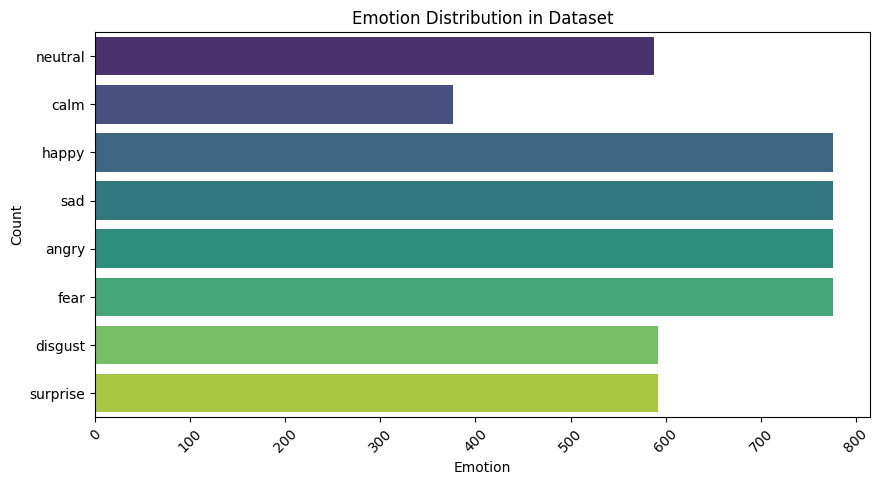

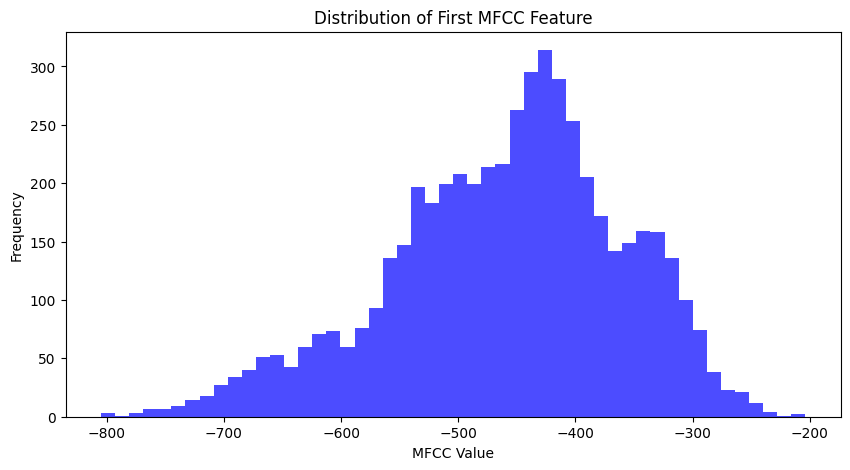

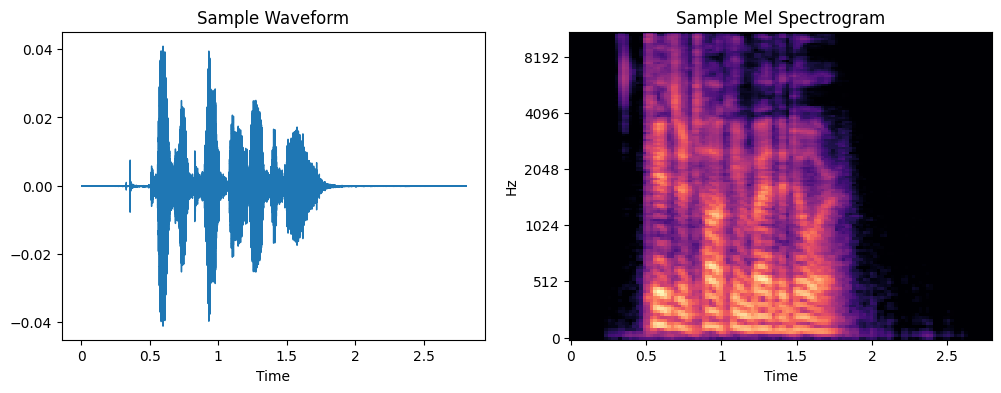

In [9]:
# Define save directory for visualizations
VISUALIZATION_DIR = r"F:\Final Year Engineering\Final Year BE Project\Visualizations" 
os.makedirs(VISUALIZATION_DIR, exist_ok=True)  # Creates the folder if it doesn't exist

# Emotion Distribution
plt.figure(figsize=(10, 5))
sns.countplot(y, palette='viridis')
plt.title('Emotion Distribution in Dataset')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.savefig(os.path.join(VISUALIZATION_DIR, 'emotion_distribution.png'))
plt.show()

# Feature Statistics (Histogram of first MFCC feature)
plt.figure(figsize=(10, 5))
plt.hist(X[:, 0], bins=50, alpha=0.7, color='blue')
plt.title('Distribution of First MFCC Feature')
plt.xlabel('MFCC Value')
plt.ylabel('Frequency')
plt.savefig(os.path.join(VISUALIZATION_DIR, 'mfcc_histogram.png'))
plt.show()

# Sample Waveform and Spectrogram (from first file)
sample_file = os.path.join(RAVDESS_SPEECH_PATH, 'Actor_01', '03-01-01-01-01-01-01.wav')  # Adjust if needed
if os.path.exists(sample_file):
    y_sample, sr = librosa.load(sample_file, duration=3, offset=0.5)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y_sample, sr=sr)
    plt.title('Sample Waveform')
    plt.subplot(1, 2, 2)
    spec = librosa.feature.melspectrogram(y=y_sample, sr=sr)
    librosa.display.specshow(librosa.power_to_db(spec, ref=np.max), sr=sr, x_axis='time', y_axis='mel')
    plt.title('Sample Mel Spectrogram')
    plt.savefig(os.path.join(VISUALIZATION_DIR, 'sample_audio.png'))
    plt.show()

## STEP:7 - Preprocessing Data - Label Encoding, Scaling, Splitting and Reshaping 

In [10]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y_encoded,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape, X_test.shape)

(4201, 193) (1051, 193)


In [13]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape)
print(X_test.shape)

(4201, 193, 1)
(1051, 193, 1)


## STEP:8 - Defining MLP MODEL and Fitting model

In [14]:
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),

    Dense(256, activation='relu'),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.25),

    Dense(len(np.unique(y_encoded)), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               99328     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 

In [15]:
history = model.fit(
    X_train,
    y_train,
    epochs=80,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/80


105/105 [==============================] - 2s 7ms/step - loss: 1.4839 - accuracy: 0.4670 - val_loss: 0.9329 - val_accuracy: 0.7122
Epoch 2/80
105/105 [==============================] - 0s 5ms/step - loss: 0.9552 - accuracy: 0.6643 - val_loss: 0.6900 - val_accuracy: 0.7551
Epoch 3/80
105/105 [==============================] - 0s 5ms/step - loss: 0.7492 - accuracy: 0.7375 - val_loss: 0.5933 - val_accuracy: 0.8026
Epoch 4/80
105/105 [==============================] - 0s 5ms/step - loss: 0.6530 - accuracy: 0.7646 - val_loss: 0.5276 - val_accuracy: 0.8193
Epoch 5/80
105/105 [==============================] - 1s 5ms/step - loss: 0.5841 - accuracy: 0.7875 - val_loss: 0.4923 - val_accuracy: 0.8264
Epoch 6/80
105/105 [==============================] - 0s 5ms/step - loss: 0.5519 - accuracy: 0.7982 - val_loss: 0.4792 - val_accuracy: 0.8395
Epoch 7/80
105/105 [==============================] - 0s 5ms/step - loss: 0.5076 - accuracy: 0.8134 - val_loss: 0.4648 - val_accuracy: 0.8335
Epoc

## STEP:9 - Model Evaluation -- (Accuracy, Classification Report, Confusion Matrix)

In [16]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

33/33 [==============================] - 0s 2ms/step - loss: 0.6458 - accuracy: 0.8677
Test Accuracy: 86.77%


In [17]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

emotion_map = {
    0: "Neutral",
    1: "Calm",
    2: "Happy",
    3: "Sad",
    4: "Angry",
    5: "Fearful",
    6: "Disgust",
    7: "Surprised"
}

target_names = [emotion_map[i] for i in sorted(emotion_map)]

print(classification_report(
    y_test,
    y_pred,
    target_names=target_names
))

33/33 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

     Neutral       0.89      0.92      0.90       138
        Calm       0.82      0.84      0.83        79
       Happy       0.90      0.82      0.86       110
         Sad       0.82      0.90      0.86       155
       Angry       0.92      0.75      0.83       159
     Fearful       0.93      0.92      0.93       117
     Disgust       0.89      0.87      0.88       172
   Surprised       0.78      0.92      0.84       121

    accuracy                           0.87      1051
   macro avg       0.87      0.87      0.87      1051
weighted avg       0.87      0.87      0.87      1051



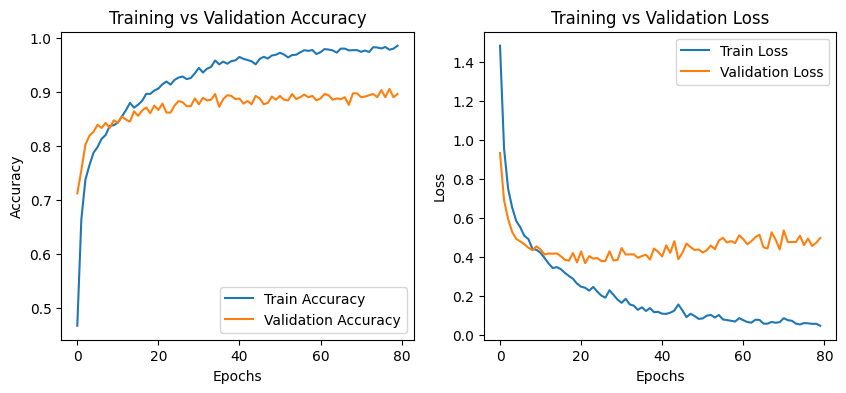

In [18]:
plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.savefig(os.path.join(VISUALIZATION_DIR, 'MLP_Training_Validation_Accuracy.png'))

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.savefig(os.path.join(VISUALIZATION_DIR, 'MLP_Training_Validation_loss.png'))
plt.show()


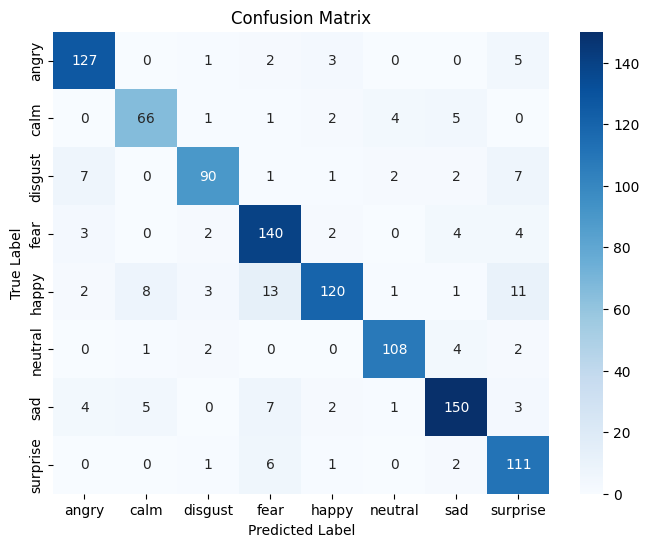

<Figure size 640x480 with 0 Axes>

In [19]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=encoder.classes_,
    yticklabels=encoder.classes_
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
plt.savefig(os.path.join(VISUALIZATION_DIR, 'MLP_Confusion_Matrix.png'))

In [20]:
print("Overall Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1-score:", f1_score(y_test, y_pred, average='macro'))
print("Weighted F1-score:", f1_score(y_test, y_pred, average='weighted'))

Overall Accuracy: 0.8677450047573739
Macro F1-score: 0.866333931783186
Weighted F1-score: 0.8674726233110316


## STEP:10 - Prepare data for XGBoost 
#### Another Model for Comparison 

In [21]:
# XGBoost expects 2D data
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
X_test_xgb  = X_test.reshape(X_test.shape[0], -1)

print(X_train_xgb.shape, X_test_xgb.shape)

(4201, 193) (1051, 193)


## STEP:11 - Train XGBoost model

In [22]:
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(encoder.classes_),
    n_estimators=500,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.85,
    colsample_bytree=0.85,
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_xgb, y_train)

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.85
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


## STEP:12 - Evaluate XGBoost model

In [23]:
y_pred_xgb = xgb_model.predict(X_test_xgb)

print(f"XGBoost Test Accuracy: {accuracy_score(y_test, y_pred_xgb) * 100:.2f}%")

print("\nClassification Report (XGBoost):")
print(classification_report(
    y_test,
    y_pred_xgb,
    target_names=encoder.classes_
))

print("\nConfusion Matrix (XGBoost):")
print(confusion_matrix(y_test, y_pred_xgb))

XGBoost Test Accuracy: 86.68%

Classification Report (XGBoost):
              precision    recall  f1-score   support

       angry       0.95      0.90      0.92       138
        calm       0.80      0.87      0.84        79
     disgust       0.81      0.83      0.82       110
        fear       0.84      0.89      0.86       155
       happy       0.86      0.81      0.83       159
     neutral       0.91      0.93      0.92       117
         sad       0.86      0.83      0.84       172
    surprise       0.90      0.91      0.91       121

    accuracy                           0.87      1051
   macro avg       0.87      0.87      0.87      1051
weighted avg       0.87      0.87      0.87      1051


Confusion Matrix (XGBoost):
[[124   0   3   3   3   0   1   4]
 [  0  69   1   1   4   4   0   0]
 [  0   4  91   2   6   2   3   2]
 [  0   0   3 138   1   1  12   0]
 [  4   4   5  11 128   1   2   4]
 [  1   1   0   0   0 109   5   1]
 [  1   8   5   8   5   2 142   1]
 [  1   0  

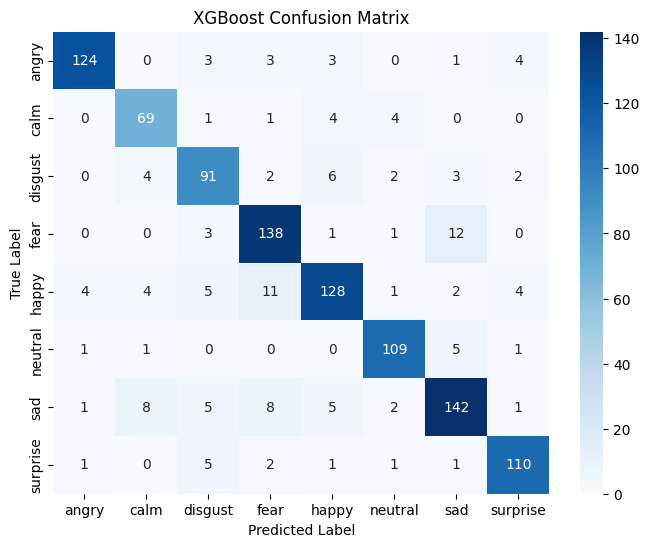

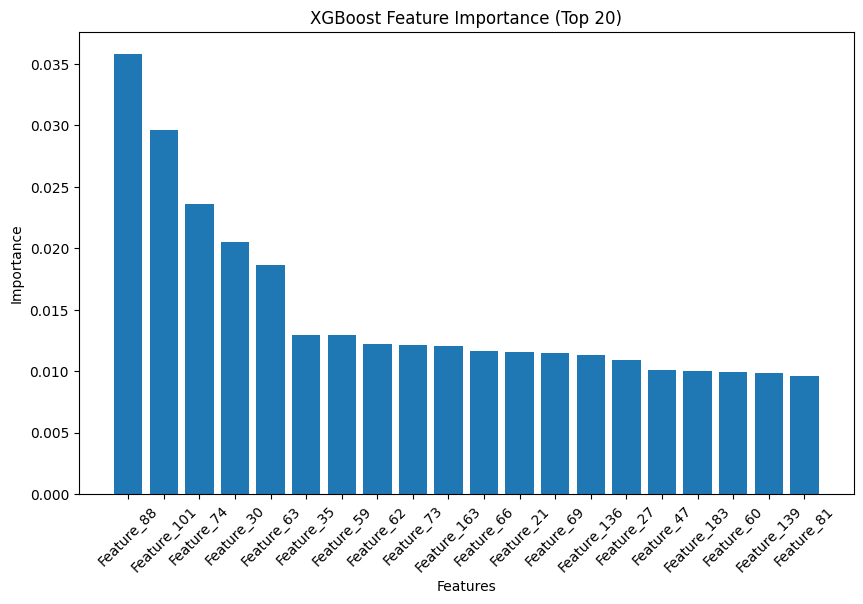

XGBoost Accuracy: 86.68%
              precision    recall  f1-score   support

       angry       0.95      0.90      0.92       138
        calm       0.80      0.87      0.84        79
     disgust       0.81      0.83      0.82       110
        fear       0.84      0.89      0.86       155
       happy       0.86      0.81      0.83       159
     neutral       0.91      0.93      0.92       117
         sad       0.86      0.83      0.84       172
    surprise       0.90      0.91      0.91       121

    accuracy                           0.87      1051
   macro avg       0.87      0.87      0.87      1051
weighted avg       0.87      0.87      0.87      1051

[[124   0   3   3   3   0   1   4]
 [  0  69   1   1   4   4   0   0]
 [  0   4  91   2   6   2   3   2]
 [  0   0   3 138   1   1  12   0]
 [  4   4   5  11 128   1   2   4]
 [  1   1   0   0   0 109   5   1]
 [  1   8   5   8   5   2 142   1]
 [  1   0   5   2   1   1   1 110]]


In [24]:
# XGBoost Model Visulization of Evaluation

# XGBoost Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig(os.path.join(VISUALIZATION_DIR, 'xgb_confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

# XGBoost Feature Importance
plt.figure(figsize=(10, 6))
feature_names = [f'Feature_{i}' for i in range(X_train_xgb.shape[1])]  # Generic names; customize if you have real names
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1][:20]  # Top 20 features
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45)
plt.title('XGBoost Feature Importance (Top 20)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.savefig(os.path.join(VISUALIZATION_DIR, 'xgb_feature_importance.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"XGBoost Accuracy: {accuracy_score(y_test, y_pred_xgb) * 100:.2f}%")
print(classification_report(y_test, y_pred_xgb, target_names=encoder.classes_))
print(confusion_matrix(y_test, y_pred_xgb))

In [25]:
os.makedirs("models", exist_ok=True)
os.makedirs("data", exist_ok=True)

In [26]:
# Save MLP model (recommended format)
model.save("models/mlp_model.keras")

# Save XGBoost model
joblib.dump(xgb_model, "models/xgb_model.pkl")

['models/xgb_model.pkl']

In [27]:
#Save preprocessing objects
joblib.dump(scaler, "models/scaler.pkl")
joblib.dump(encoder, "models/label_encoder.pkl")

['models/label_encoder.pkl']

In [28]:
np.savez(
    "data/features.npz",
    X=X,
    y=y
)

In [29]:
import tensorflow as tf
import keras
print("TF:", tf.__version__)
print("Keras:", keras.__version__)

TF: 2.15.0
Keras: 2.15.0
